In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
import sys
sys.path.append('../../')
from PortfolioAnalysis import Backtest
from PortfolioAnalysis import Model

In [2]:
def inv(df):
    return pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)

In [233]:
class BL:
    '''
    Black-Litterman is used to get the final combination weight
    Input:
    
    
    
    '''
    def __init__(self, df_date, df_history, df_fr, market_view, sub_view):
        self.df_date = df_date
        self.df_history = df_history
        self.df_fr = df_fr
        

        # market_view为风险评价模型观点矩阵
        # sub_view为宏观数据算出的主观观点矩阵
        self.market_view = market_view
        self.sub_view = sub_view
        
        # 权重
        ay_weight = self.market_view.iloc[[0]]
        
        # 期望收益率平均值
        df_r = np.log(df_history/df_history.shift(1))
        market_r = (self.market_view*np.array(df_r)).dropna()
        E_r = market_r.sum().sum()
        
        # 收益率标准差
        market_sigma = np.std(market_r.sum(axis=1))
        
        # 无风险利率平均值
        mean_fr = df_fr.mean()
        
        # 风险厌恶系数
        Lambda = ((E_r-mean_fr)/(market_sigma))[0]
        self.Lambda = Lambda
        
        # 资产收益率协方差矩阵(n*n)
        market_cov = df_r.corr() 
        
        # 先验收益率（n*1） = Lambda*协方差矩阵（n*n）*权重（n*1）
        Sigma = Lambda * np.dot(market_cov , ay_weight.T)
        self.Sigma = Sigma
        
        # 观点收益Q
        sub_view = self.sub_view
        Q = sub_view[sub_view.columns[len(sub_view.columns)-1]] .sum()
        
        # 观点信心水平LC默认为80%
        LC = 0.8
        
        # CF
        P = (self.sub_view.sum(axis=0))[:-1]
        P = pd.DataFrame(P).T
        CF = np.dot(np.dot(P,market_cov),P.T)[0]
        
        # 观点误差矩阵
        Omega = pd.DataFrame([CF/LC])
        
        # 投资者信心程度，默认为1
        tao = 1
        self.tao = tao
        
        # 后验收益率 E(R)
        E_R = np.dot(inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P)),\
                         (np.dot(inv(tao*market_cov),self.Sigma)+(np.dot(np.dot(P.T,inv(Omega)),Q))))
        self.E_R = E_R
        
        # 新收益率协方差矩阵
        new_cov = inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P))
        self.new_cov = new_cov
        
        
        # 新的权重
        
        a="{'type': 'eq', 'fun': lambda w: w.sum() - 1},"
        for i in range(15):
            a = a +"{'type': 'ineq', 'fun': lambda w: w["+str(i)+"] + 0.2},\
            {'type': 'ineq', 'fun': lambda w: 1 - w["+str(i)+"]},"
        
        cons = ({'type': 'eq', 'fun': lambda w: w.sum() - 1},\
                {'type': 'ineq', 'fun': lambda w: w[0] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[0]},\
                {'type': 'ineq', 'fun': lambda w: w[1] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[1]},\
                {'type': 'ineq', 'fun': lambda w: w[2] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[2]},\
                {'type': 'ineq', 'fun': lambda w: w[3] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[3]},\
                {'type': 'ineq', 'fun': lambda w: w[4] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[4]},\
                {'type': 'ineq', 'fun': lambda w: w[5] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[5]},\
                {'type': 'ineq', 'fun': lambda w: w[6] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[6]},\
                {'type': 'ineq', 'fun': lambda w: w[7] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[7]},\
                {'type': 'ineq', 'fun': lambda w: w[8] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[8]},\
                {'type': 'ineq', 'fun': lambda w: w[9] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[9]},\
                {'type': 'ineq', 'fun': lambda w: w[10] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[10]},\
                {'type': 'ineq', 'fun': lambda w: w[11] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[11]},\
                {'type': 'ineq', 'fun': lambda w: w[12] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[12]},\
                {'type': 'ineq', 'fun': lambda w: w[13] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[13]},\
                {'type': 'ineq', 'fun': lambda w: w[14] + 0.2},\
                {'type': 'ineq', 'fun': lambda w: 1 - w[14]})
        w = np.array([1/15,]*15)
        
        
        res = optimize.minimize(utility(w),w,constraints=cons,tol = 1e-8)
        
        print(res.success)
        
        if output:
            print("Status: "+str(res.message))
        weight_new = res.x 
        weight_new = pd.DataFrame(weight_new).T
        for i in range(62):
            weight_new = weight_new.append(weight_new.iloc[0]) 
        weight_new.index = self.df_date
        self.weight_new = weight_new
        
    
    def print_E_R(self):
        return self.E_R
    
    def print_weight(self):
        return self.weight_new
        

In [234]:
market_view = pd.read_csv("../Risk_Parity_Model/view.csv",index_col = 0)
sub_view = pd.read_csv("../Subjective_View_Setting/Subjective_View.csv",index_col = 0)
df_history = pd.read_csv("../../Data/Data_Outsample.csv",index_col = 0)[:-28]
df_history_all = pd.read_csv("../../Data/Data_All.csv",index_col = 0)
df_date = market_view.index
df_fr = pd.DataFrame(np.repeat(0,1134))

In [235]:
view_new = pd.DataFrame(columns = df_history.columns)
start = 0
while(True):
    print("start = %d"%start)
    if(start+63>len(df_date)):
        break
    bl = BL(df_date[start:start+63], df_history[start:start+63], df_fr[start:start+63],\
            market_view[start:start+63], sub_view[start:start+63])
    view_new = pd.concat([view_new,bl.print_weight()])
    start = start + 63
view_new = view_new.dropna(axis=1)
view_new.columns = df_history.columns

start = 0


TypeError: 'numpy.float64' object is not callable

In [68]:
# tao=1
BT = Backtest.Backtest(df_date, df_history_all[252*3:252*3+63*18], view_new, df_fr, 'D')
BT.get_info()

Sharpe  Annualized Return  Annualized Volatility  Maximum Drawdown
Value  0.052732           0.271965               5.157539          0.287557

In [49]:
df_bm = pd.DataFrame(np.repeat(np.array([[1/15,]*15]),63*18,axis=0))

In [20]:
BTM = Backtest.Backtest(df_date, df_history_all[252*3:252*3+63*18], df_bm, df_fr, 'D')
BTM.get_info()

Sharpe  Annualized Return  Annualized Volatility  Maximum Drawdown
Value  0.025518           0.087254               3.419271          0.774552

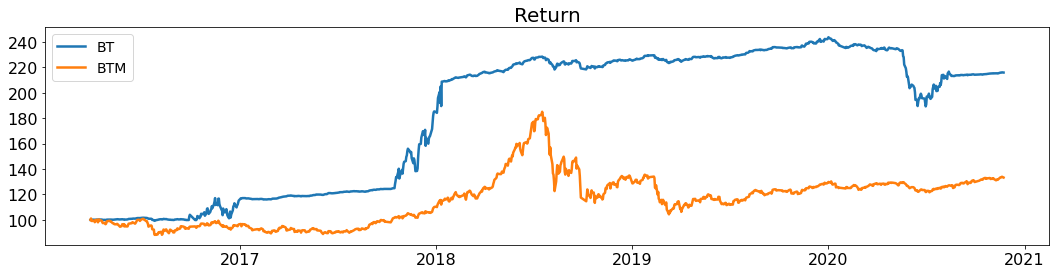

In [38]:
Backtest.Plot2(df_date,BT.df_asset,BTM.df_asset,"Return","BT","BTM")

In [348]:
Asset = pd.DataFrame([BT.df_asset,BTM.df_asset]).T
Asset.index = df_date
Asset.columns = ['BL','Market']

In [353]:
Asset.to_csv("BL_Asset.csv")

In [51]:
view_new.to_csv("view.csv")

In [241]:
df_date = df_date[0:63]
df_history = df_history[0:63]
df_fr = df_fr[0:63]
market_view = market_view[0:63]
sub_view = sub_view[0:63]

In [245]:
def utility(w):
            u = (w.T.dot(E_R)-(Lambda/2)*np.dot(wt,new_cov).dot(w))[0]
            return -u

In [246]:
        ay_weight = market_view.iloc[[0]]
        
        # 期望收益率平均值
        df_r = np.log(df_history/df_history.shift(1))
        market_r = (market_view*np.array(df_r)).dropna()
        E_r = market_r.sum().sum()
        
        # 收益率标准差
        market_sigma = np.std(market_r.sum(axis=1))
        
        # 无风险利率平均值
        mean_fr = df_fr.mean()
        
        # 风险厌恶系数
        Lambda = ((E_r-mean_fr)/(market_sigma))[0]
        
        # 资产收益率协方差矩阵(n*n)
        market_cov = df_r.corr() 
        
        # 先验收益率（n*1） = Lambda*协方差矩阵（n*n）*权重（n*1）
        Sigma = Lambda * np.dot(market_cov , ay_weight.T)
        
        # 观点收益Q
        Q = sub_view[sub_view.columns[len(sub_view.columns)-1]] .sum()
        
        # 观点信心水平LC默认为80%
        LC = 0.8
        
        # CF
        P = (sub_view.sum(axis=0))[:-1]
        P = pd.DataFrame(P).T
        CF = np.dot(np.dot(P,market_cov),P.T)[0]
        
        # 观点误差矩阵
        Omega = pd.DataFrame([CF/LC])
        
        # 投资者信心程度，默认为1
        tao = 1.3
        
        # 后验收益率 E(R)
        E_R = np.dot(inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P)),(np.dot(inv(tao*market_cov),Sigma)+(np.dot(np.dot(P.T,inv(Omega)),Q))))
        
        # 新收益率协方差矩阵
        new_cov = inv(inv(tao*market_cov)+np.dot(np.dot(P.T,inv(Omega)),P))
       
        # 新的权重
        
        
        a="{'type': 'eq', 'fun': lambda w: w.sum() - 1},"
        for i in range(15):
            a = a +"{'type': 'ineq', 'fun': lambda w: w["+str(i)+"] + Range},\
            {'type': 'ineq', 'fun': lambda w: Range - w["+str(i)+"]},"
        Range = 1
        cons = (eval(a[:-1]))
        w = np.array([1/15,]*15)
        res = optimize.minimize(utility(w),w,constraints=cons,tol = 1e-8)
        if output:
            print("Status: "+str(res.message))
        weight_new = res.x    
        weight_new = pd.DataFrame(weight_new).T
        for i in range(62):
            weight_new = weight_new.append(weight_new.iloc[0]) 
        weight_new.index = df_date
        
        
'''       
        weight_new = inv(Lambda*new_cov).dot(E_R).T
        for i in range(62):
            weight_new = weight_new.append(weight_new.iloc[0]) 
        weight_new.index = df_date
        weight_new = weight_new
'''

TypeError: 'numpy.float64' object is not callable

In [155]:
w = pd.DataFrame(np.array([[1/15,]*15]))

In [157]:
w = pd.DataFrame(np.array([1/15,]*15))

In [158]:
w

0
0   0.066667
1   0.066667
2   0.066667
3   0.066667
4   0.066667
5   0.066667
6   0.066667
7   0.066667
8   0.066667
9   0.066667
10  0.066667
11  0.066667
12  0.066667
13  0.066667
14  0.066667

In [106]:
w = w.T

In [108]:
E_R

array([[2.51185679],
       [2.43105397],
       [1.64750512],
       [2.74080393],
       [2.95792849],
       [2.58920179],
       [5.17030149],
       [5.05885128],
       [5.33479773],
       [0.02914973],
       [0.9873429 ],
       [2.86426298],
       [2.54133281],
       [3.23305402],
       [0.05003852]])

In [118]:
wt = w.T

In [124]:
np.dot(wt,new_cov).dot(w)

array([[0.55308078]])

0   -0.367172
Name: 0, dtype: float64

In [145]:
weight_new = pd.DataFrame(weight_new).T
for i in range(62):
    weight_new = weight_new.append(weight_new.iloc[0]) 

In [139]:
pd.DataFrame(weight_new)

0    0.999997
0    0.999997
0    0.999997
0    0.999997
0    0.999997
       ...   
0    0.999997
0    0.999997
0    0.999997
0    0.999997
0    0.999997
Length: 63, dtype: float64